<a href="https://colab.research.google.com/github/PatrizioPerugini/MOD_VISIOPE/blob/main/proj_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/PatrizioPerugini/MOD_VISIOPE.git

Cloning into 'MOD_VISIOPE'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [10]:
import zipfile


zip_ref = zipfile.ZipFile('/content/MOD_VISIOPE/Chess_ds.coco.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/MOD_VISIOPE') #Extracts the files into the /tmp folder
zip_ref.close()

In [11]:
%cd /content/MOD_VISIOPE/
%ls

/content/MOD_VISIOPE
Chess_ds.coco.zip   README.md            test/   valid/
README.dataset.txt  README.roboflow.txt  train/


In [2]:
!pip install -U torchvision 

In [3]:
#import pytorch 
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
#import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [5]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [6]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [7]:
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [32]:
def get_transforms(train=False):
   transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
   return transform

In [33]:
class Chess_ds(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [14]:
dataset_path = "/content/MOD_VISIOPE/"

In [34]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


{0: {'id': 0, 'name': 'pieces', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bishop', 'supercategory': 'pieces'},
 2: {'id': 2, 'name': 'black-bishop', 'supercategory': 'pieces'},
 3: {'id': 3, 'name': 'black-king', 'supercategory': 'pieces'},
 4: {'id': 4, 'name': 'black-knight', 'supercategory': 'pieces'},
 5: {'id': 5, 'name': 'black-pawn', 'supercategory': 'pieces'},
 6: {'id': 6, 'name': 'black-queen', 'supercategory': 'pieces'},
 7: {'id': 7, 'name': 'black-rook', 'supercategory': 'pieces'},
 8: {'id': 8, 'name': 'white-bishop', 'supercategory': 'pieces'},
 9: {'id': 9, 'name': 'white-king', 'supercategory': 'pieces'},
 10: {'id': 10, 'name': 'white-knight', 'supercategory': 'pieces'},
 11: {'id': 11, 'name': 'white-pawn', 'supercategory': 'pieces'},
 12: {'id': 12, 'name': 'white-queen', 'supercategory': 'pieces'},
 13: {'id': 13, 'name': 'white-rook', 'supercategory': 'pieces'}}

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

['pieces',
 'bishop',
 'black-bishop',
 'black-king',
 'black-knight',
 'black-pawn',
 'black-queen',
 'black-rook',
 'white-bishop',
 'white-king',
 'white-knight',
 'white-pawn',
 'white-queen',
 'white-rook']

In [35]:
train_dataset = Chess_ds(root=dataset_path, transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


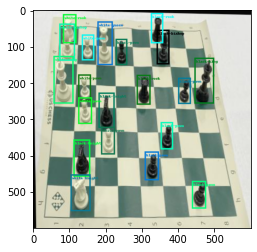

In [46]:
# As good practice, let's view a sample!
sample = train_dataset[torch.randint(1,606,(1,))]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [25]:
len(train_dataset)

606